### SETTING UP THE ENV

Lets impot Libraries

In [1]:
#download necessary libraries

!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.6 MB/s eta 0:00:00


In [2]:
import sys
sys.path.append('/kaggle/working')
# !ls /kaggle/working
import torch
print(torch.__version__)
print(torch.version.cuda)

2.1.2
12.1


In [3]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn.conv import MessagePassing

In [4]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax
from sklearn.metrics import r2_score
from sklearn.neighbors import NearestNeighbors

# Pre Processing

In [5]:
df = pd.read_csv('/kaggle/input/cms-dataset/CMS_trigger.csv')
print(df.columns)

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle'],
      dtype='object')


In [6]:
df.head()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
0,0,58.066666,55.466667,55.466667,56.000000,11.970,11.684999,11.400,11.400,-13.000000,...,0.0,0.0,0.0,0.0,5.0,3.0,105.0,0.181209,-3.075936,1.722345
1,1,64.583336,66.800000,67.066666,67.200000,6.555,6.840000,6.555,6.840,7.000000,...,0.0,0.0,0.0,0.0,3.0,1.0,124.0,-0.146131,-0.167139,2.012122
2,2,71.150000,67.033330,66.266670,65.466670,2.850,2.565000,2.280,2.280,-16.613783,...,0.0,0.0,0.0,0.0,7.0,0.0,127.0,0.367024,2.431823,2.321646
3,3,34.933334,31.200000,31.200000,31.833334,9.690,8.835000,8.835,9.120,-13.000000,...,0.0,0.0,0.0,0.0,6.0,2.0,60.0,0.267774,-1.343305,1.854506
4,4,68.150000,68.266670,68.300000,68.400000,2.565,2.565000,2.565,2.565,0.000000,...,0.0,0.0,0.0,0.0,4.0,0.0,128.0,-0.019179,-3.134433,2.333772


In [7]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_0,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00


In [8]:
#HOW MOMENTUM NEGATIVE??

**The data is not scaled, so we would have to scale the data first before we proceed to train a model on the data**

**To begin with lets  scale the data by using Standard Scalar**

In [9]:
scaler = StandardScaler()

In [10]:
df.shape

(1179356, 35)

In [11]:
df.loc[:,"pT"] = abs(1/df.loc[:,"q/pt"])

In [12]:
label =df.loc[:,"pT"]

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = label.quantile(0.25)
Q3 = label.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

In [13]:
# Define the acceptable range (1.5 times the IQR below Q1 and above Q3)
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(label >= lower_bound) & (label <= upper_bound)]
filtered_df = filtered_df.reset_index(drop=True)
# Extract the indices of the filtered dataset
filtered_indices = filtered_df.index.to_numpy()

# Split the filtered indices into training and test sets
train_idx, test_idx = train_test_split(filtered_indices, test_size=0.2, random_state=1)

In [14]:
filtered_df.loc[:,"Phi_0":] = scaler.fit_transform(filtered_df.loc[:,"Phi_0":])

In [15]:
df.columns

Index(['Unnamed: 0', 'Phi_0', 'Phi_2', 'Phi_3', 'Phi_4', 'Theta_0', 'Theta_2',
       'Theta_3', 'Theta_4', 'BendingAngle_0', 'BendingAngle_2',
       'BendingAngle_3', 'BendingAngle_4', 'TimeInfo_0', 'TimeInfo_2',
       'TimeInfo_3', 'TimeInfo_4', 'RingNumber_0', 'RingNumber_2',
       'RingNumber_3', 'RingNumber_4', 'Front_0', 'Front_2', 'Front_3',
       'Front_4', 'Mask_0', 'Mask_2', 'Mask_3', 'Mask_4',
       'PatternStraightness', 'Zone', 'MedianTheta', 'q/pt', 'PhiAngle',
       'EtaAngle', 'pT'],
      dtype='object')

In [16]:
df.describe()

,Unnamed: 0,Phi_0,Phi_2,Phi_3,Phi_4,Theta_0,Theta_2,Theta_3,Theta_4,BendingAngle_0,...,Mask_2,Mask_3,Mask_4,PatternStraightness,Zone,MedianTheta,q/pt,PhiAngle,EtaAngle,pT
count,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,...,1179356.0,1179356.0,1179356.0,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06,1.179356e+06
mean,5.896775e+05,4.851559e+01,4.851127e+01,4.851076e+01,4.851331e+01,6.195453e+00,5.918753e+00,5.848332e+00,5.881490e+00,5.603115e-02,...,0.0,0.0,0.0,3.976490e+00,1.080514e+00,9.115961e+01,5.540485e-04,8.881380e-04,8.762006e-04,2.048443e+01
std,3.404509e+05,1.774647e+01,1.779697e+01,1.781670e+01,1.779750e+01,3.011983e+00,2.921076e+00,2.911875e+00,2.906416e+00,1.493805e+01,...,0.0,0.0,0.0,1.871622e+00,1.089190e+00,3.328909e+01,2.524173e-01,1.820920e+00,2.075298e+00,1.350444e+02
min,0.000000e+00,1.103333e+01,2.400000e+00,2.666667e+00,2.666667e+00,1.425000e+00,1.425000e+00,1.425000e+00,1.710000e+00,-1.329103e+02,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,8.000000e+00,-4.999928e-01,-3.141584e+00,-2.499009e+00,2.000004e+00
25%,2.948388e+05,3.371667e+01,3.360000e+01,3.360000e+01,3.360000e+01,3.705000e+00,3.420000e+00,3.420000e+00,3.420000e+00,-1.100000e+01,...,0.0,0.0,0.0,3.000000e+00,0.000000e+00,6.300000e+01,-2.055347e-01,-1.584667e+00,-2.074832e+00,3.129539e+00
50%,5.896775e+05,4.830000e+01,4.826667e+01,4.826667e+01,4.826667e+01,5.700000e+00,5.415000e+00,5.415000e+00,5.415000e+00,0.000000e+00,...,0.0,0.0,0.0,4.000000e+00,1.000000e+00,9.100000e+01,2.155910e-04,8.142424e-03,1.523139e+00,4.848820e+00
75%,8.845162e+05,6.326667e+01,6.303333e+01,6.293333e+01,6.296667e+01,8.265000e+00,7.980000e+00,7.695000e+00,7.980000e+00,1.100000e+01,...,0.0,0.0,0.0,5.000000e+00,2.000000e+00,1.180000e+02,2.069167e-01,1.581958e+00,2.074729e+00,9.962329e+00
max,1.179355e+06,8.311667e+01,8.256667e+01,8.253333e+01,8.253333e+01,1.510500e+01,1.396500e+01,1.539000e+01,1.510500e+01,1.421401e+02,...,0.0,0.0,0.0,8.000000e+00,4.000000e+00,1.540000e+02,4.999991e-01,3.141592e+00,2.493834e+00,6.955571e+03


**We can see that the std dev and the mean has been transformed to 1 and 0 respectively**

In [17]:
features = list(df.columns)[1:29]
features

['Phi_0',
 'Phi_2',
 'Phi_3',
 'Phi_4',
 'Theta_0',
 'Theta_2',
 'Theta_3',
 'Theta_4',
 'BendingAngle_0',
 'BendingAngle_2',
 'BendingAngle_3',
 'BendingAngle_4',
 'TimeInfo_0',
 'TimeInfo_2',
 'TimeInfo_3',
 'TimeInfo_4',
 'RingNumber_0',
 'RingNumber_2',
 'RingNumber_3',
 'RingNumber_4',
 'Front_0',
 'Front_2',
 'Front_3',
 'Front_4',
 'Mask_0',
 'Mask_2',
 'Mask_3',
 'Mask_4']

In [18]:
# Lets split the data into train and the test splits

In [19]:
scaler.scale_[34]

3.9377537017281714

In [20]:
# Extract features and labels
x_data = filtered_df[features].to_numpy()
label = filtered_df['pT'].to_numpy()

# Ensure the shapes of x_data and label
assert x_data.shape[0] == label.shape[0], "Mismatch between x_data and label sizes"

# Print the new data shape and label shape
print('Data shape: ' + str(x_data.shape))
print(label.shape)
print('Len train: ' + str(len(train_idx)) + ', Len test: ' + str(len(test_idx)))
print('Num. features: ' + str(x_data.shape[-1]))

Data shape: (1029592, 28)
(1029592,)
Len train: 823673, Len test: 205919
Num. features: 28


In [21]:
min_PT, max_pT = label.min(), label.max()

# Dataset Class and Data Loaders

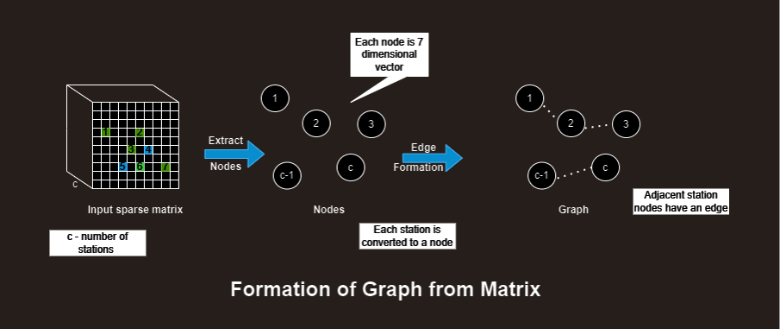

**The dataset is having 28 features extracted from 4 triggers ie 7 features per trigger**

**Total approached to try**

---------------------------------------------------------------------------------------------------------------------------
**(THIS NOTEBOOK)**

- [x] **Each station as a node : 
    Here basically each station(4),is made a node of the graph and the node feature is the features recieved at the respective station(7)**
    
    Here,
         Total nodes = 4
         node feature length = 7
         edges should be between these 4 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
    
    
---------------------------------------------------------------------------------------------------------------------------
- [ ] **Each feature as a node :
    Here basically each feature obtianed from different stations, here 4 stations are made a node of the graph and 
    the node feature is the values of this feature across the 4 different stations**
    
    Here,
         Total nodes = 7
         node feature length = 4
         edges should be between these 7 nodes (Yet to find out the best way to decide across which two nodes there should be and edge)
         
---------------------------------------------------------------------------------------------------------------------------

- [ ]  **Each patch as a node :
    Here basically the data is converted into 7*4 matrix and then would have to split this into patches and then the features of the noden would be the flattened pixel values in each patch**
    
    Here,
         Total nodes = total_patches 
         node feature length = pixels in each path
         edges should be between these patch nodes (Yet to find out the best way to decide across which two nodes there should be and edge
         
---------------------------------------------------------------------------------------------------------------------------

In [22]:
# x_data.shape

In [23]:
class Graph_dataset(Dataset):
    def __init__(self, dataset , label,  edge_index, indices, transform=None):
        self.transform = transform
        self.data = dataset
        self.edge_index = edge_index
        self.indices = indices
        self.label = label
    
    def __getitem__(self, idx):
        return self.convert_to_graph(self.indices[idx])
    
    def __len__(self):
        return len(self.indices)
    
    def convert_to_graph(self, i):
    
        data = Data(x=torch.tensor(self.data[i].reshape(-1,4).T, dtype=torch.float), y=torch.tensor(self.label[i], dtype=torch.float),
                    edge_index=torch.tensor(self.edge_index, dtype = torch.long).T)
        return data

In [24]:
edge_index = [(0,1),(1,2),(2,3),(3,2),(2,1),(1,0),(0,2),(0,3),(2,0),(3,0),(3,1) ]

In [25]:
train_dataset = Graph_dataset(x_data, label,edge_index, train_idx)
next(iter(train_dataset))

Data(x=[4, 7], edge_index=[2, 11], y=-0.6552883386611938)

In [26]:
import networkx as nx
import matplotlib.pyplot as plt
import random

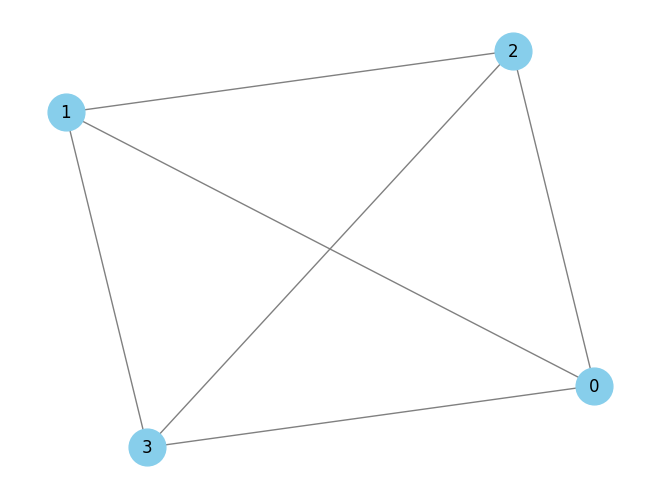

In [27]:
def plot_graph(data):
    G = nx.Graph()
    num_nodes = data.x.shape[0]
    G.add_nodes_from(range(num_nodes))
    edge_index = data.edge_index.numpy()
    edges = list(zip(edge_index[0], edge_index[1]))
    G.add_edges_from(edges)
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=700, edge_color='gray')
    plt.show()

# Select 5 random graphs from the dataset and plot them

for idx in [0]:
    graph_data = train_dataset[idx]
    plot_graph(graph_data)

**Yes we wanted the fully connected graph**

In [28]:
train_loader = DataLoader(Graph_dataset(x_data, label, edge_index , train_idx), batch_size=1024)
test_loader = DataLoader(Graph_dataset(x_data, label, edge_index , test_idx), batch_size=512)

In [29]:
next(iter(train_loader))

DataBatch(x=[4096, 7], edge_index=[2, 11264], y=[1024], batch=[4096], ptr=[1025])

**We are all set with the dataset and the dataloader**

# Lets set the Model

In [30]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
from torch_geometric.utils import to_dense_batch
import torch
import torch.nn as nn
import torch.nn.functional as F

In [31]:
class MPL(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPL, self).__init__(aggr='add')
        self.mlp1 = torch.nn.Linear(in_channels*2, out_channels)
        self.mlp2 = torch.nn.Linear(in_channels, out_channels)
        self.mlp3 = torch.nn.Linear(2*out_channels, 1)
        self.mlp4 = torch.nn.Linear(2*out_channels, 1)
        self.mlp5 = torch.nn.Linear(in_channels,16)
        self.mlp6 = torch.nn.Linear(out_channels,16)
        self.mlp7 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index):
#         edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        msg = self.propagate(edge_index, x=x)
        x = F.relu(self.mlp2(x))
        w1 = F.sigmoid(self.mlp3(torch.cat([x,msg], dim=1)))
        w2 = F.sigmoid(self.mlp4(torch.cat([x,msg], dim=1)))
        out = w1*msg + w2*x
        
        return out

    def message(self, x_i, x_j, edge_index):
        msg = F.relu(self.mlp1(torch.cat([x_i, x_j-x_i], dim=1)))
        w1 = F.tanh(self.mlp5(x_i))
        w2 = F.tanh(self.mlp6(msg))
        w = self.mlp7(w1*w2)
        w = softmax(w, edge_index[0])
        return msg*w

In [32]:
class MODEL_GNN(torch.nn.Module):
    def __init__(self):
        super(MODEL_GNN, self).__init__()
        self.conv1 = MPL(int(len(features)/4),128 )
        self.conv2 = MPL(128,64)
        self.conv3 = MPL(64,64 )
        self.conv4 = MPL(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = gnn.GlobalAttention(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x

In [33]:
# Example usage:
# Initialize your model
model = MODEL_GNN()

In [34]:
model

MODEL_GNN(
  (conv1): MPL()
  (conv2): MPL()
  (conv3): MPL()
  (conv4): MPL()
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16, out_features=1, bias=True)
  (global_att_pool1): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
  (global_att_pool2): GlobalAttention(gate_nn=Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  ), nn=None)
)

In [35]:
model(train_dataset[20])

tensor([-0.1607], grad_fn=<SqueezeBackward1>)

In [36]:
# Forward pass with input data x and edge_index

In [37]:
def train(train_loader, test_loader, prog_bar = True):
    
    train_losses, test_losses = list(), list()
    min_test_loss = float('inf')
#     criterion = nn.MSELoss()
    for epoch in range(epochs):
        train_loss = 0
        test_loss = 0
        if prog_bar:
            pbar = tqdm(train_loader,position=0)
        else:
            pbar = train_loader
            
        # train
        for data in pbar:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = CustompTLoss(out, data.y,min_PT)
            loss.backward()
            optimizer.step()
            if prog_bar:
                pbar.set_description('pTLoss: '+str(loss.cpu().detach().numpy()))
                train_loss += loss.cpu().detach().numpy()/len(train_loader)
                
        # test
        for data in test_loader:
            data = data.to(device)
            optimizer.zero_grad()
            out = model(data)
            labels = data.y
            loss = CustompTLoss(out, data.y,min_PT)
            test_loss += loss.cpu().detach().numpy()/len(test_loader)
        if test_loss<min_test_loss:
            print('Min loss changed from '+str(min_test_loss)+' to '+str(test_loss))
            min_test_loss = test_loss
            torch.save(model.state_dict(), model_name)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        if epoch > 10 and min(test_losses[-7:])>min_test_loss+1e-9:
            break
        lr_scheduler.step(test_loss)
        print('Epoch: ', str(epoch+1)+'/'+str(epochs),'| Training Loss: ', train_loss, '| Testing Loss: ', test_loss)
        
        if prog_bar and (epoch%5==0):
            plt.plot(train_losses, label="Train Loss")
            plt.plot(test_losses, label="Validation Loss")
            plt.xlabel("# Epoch")
            plt.ylabel("Loss")
            plt.legend(loc='upper right')
            plt.show()
    return train_losses, test_losses

In [38]:
def pTLossTorch(y_pred,y_true):
#     if not inv:
#         y_pred = torch.pow(y_pred,-1)
#         y_true = torch.pow(y_true,-1)
    y_t = (y_true<80).type(torch.FloatTensor)*y_true.type(torch.FloatTensor) + (y_true>=80).type(torch.FloatTensor)*(y_true<250).type(torch.FloatTensor)*y_true.type(torch.FloatTensor)**2.4 + (y_true>=160).type(torch.FloatTensor)*10 
    return torch.mean(y_t.type(torch.FloatTensor)*torch.pow((y_pred-y_true)/y_true,2).type(torch.FloatTensor))/250

def CustompTLoss(output, target, lower_pt_limit):
    
    if not isinstance(lower_pt_limit, torch.Tensor):
        lower_pt_limit = torch.tensor(lower_pt_limit)
    
    lower_pt_limit = lower_pt_limit.to(output.dtype)
    output =torch.clip(output, min=lower_pt_limit.to(device))
    loss = torch.mean((target - output)**2 + torch.gt(output, lower_pt_limit.long() * \
        (1 / (1 + torch.exp(-(output - lower_pt_limit) * 3)) - 1) + \
            torch.le(output, lower_pt_limit).long()*(-1/2)))
    return loss

In [39]:
name =  f"4MPL_Conv_Custom_pT_loss_Outliers_removed"

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from inf to 1.2004559284108445
Epoch:  1/50 | Training Loss:  1.2686431680406838 | Testing Loss:  1.2004559284108445


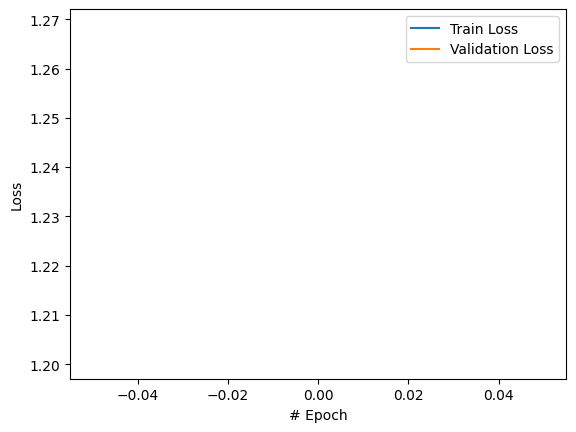

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 1.2004559284108445 to 0.8588564561555166
Epoch:  2/50 | Training Loss:  0.9170377262630806 | Testing Loss:  0.8588564561555166


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.8588564561555166 to 0.8318642613018126
Epoch:  3/50 | Training Loss:  0.858774302316748 | Testing Loss:  0.8318642613018126


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.8318642613018126 to 0.8073977570675736
Epoch:  4/50 | Training Loss:  0.8381256698081222 | Testing Loss:  0.8073977570675736


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.8073977570675736 to 0.7677481609301892
Epoch:  5/50 | Training Loss:  0.8038907034796966 | Testing Loss:  0.7677481609301892


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.7677481609301892 to 0.6687182832888272
Epoch:  6/50 | Training Loss:  0.7182828719571509 | Testing Loss:  0.6687182832888272


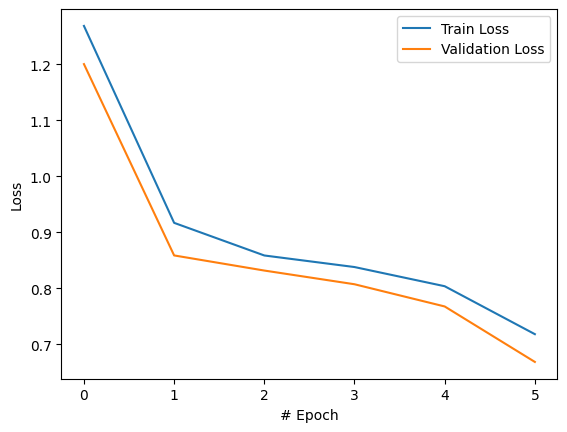

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.6687182832888272 to 0.6252003664857996
Epoch:  7/50 | Training Loss:  0.6366977844179051 | Testing Loss:  0.6252003664857996


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.6252003664857996 to 0.6071834546460696
Epoch:  8/50 | Training Loss:  0.6074178275114257 | Testing Loss:  0.6071834546460696


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.6071834546460696 to 0.5957066209677138
Epoch:  9/50 | Training Loss:  0.5929741358164673 | Testing Loss:  0.5957066209677138


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5957066209677138 to 0.5868678085561426
Epoch:  10/50 | Training Loss:  0.5827346886907305 | Testing Loss:  0.5868678085561426


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5868678085561426 to 0.5799952637468914
Epoch:  11/50 | Training Loss:  0.5747400602198529 | Testing Loss:  0.5799952637468914


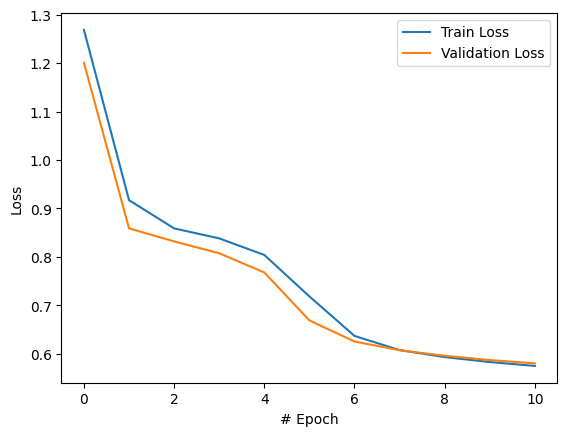

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5799952637468914 to 0.5731884499933229
Epoch:  12/50 | Training Loss:  0.5683645319494405 | Testing Loss:  0.5731884499933229


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5731884499933229 to 0.5685539743296855
Epoch:  13/50 | Training Loss:  0.5632318223115074 | Testing Loss:  0.5685539743296855


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5685539743296855 to 0.5650450010453497
Epoch:  14/50 | Training Loss:  0.5604356837198593 | Testing Loss:  0.5650450010453497


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5650450010453497 to 0.5615982539008928
Epoch:  15/50 | Training Loss:  0.5572844175078112 | Testing Loss:  0.5615982539008928


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5615982539008928 to 0.559130141811986
Epoch:  16/50 | Training Loss:  0.5550566930208147 | Testing Loss:  0.559130141811986


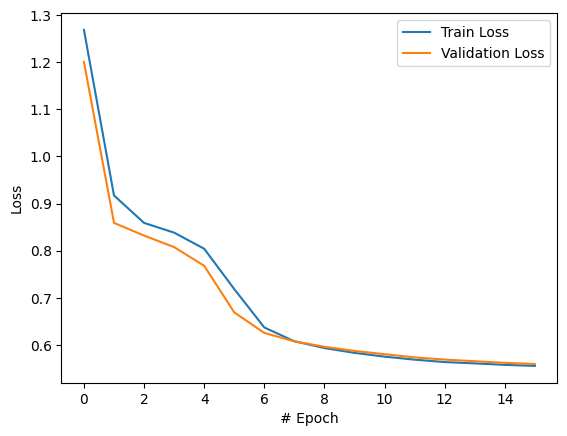

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.559130141811986 to 0.5572576102784488
Epoch:  17/50 | Training Loss:  0.5531632991681191 | Testing Loss:  0.5572576102784488


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5572576102784488 to 0.5549761764612743
Epoch:  18/50 | Training Loss:  0.5513327833658421 | Testing Loss:  0.5549761764612743


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5549761764612743 to 0.5533497395645592
Epoch:  19/50 | Training Loss:  0.5496460959407847 | Testing Loss:  0.5533497395645592


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5533497395645592 to 0.5514502655483652
Epoch:  20/50 | Training Loss:  0.5479219123443456 | Testing Loss:  0.5514502655483652


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5514502655483652 to 0.5501420835851142
Epoch:  21/50 | Training Loss:  0.5462820050879291 | Testing Loss:  0.5501420835851142


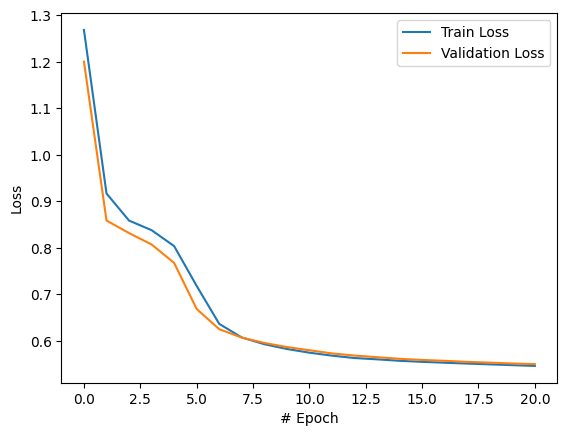

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5501420835851142 to 0.5486591515263027
Epoch:  22/50 | Training Loss:  0.5445505278821317 | Testing Loss:  0.5486591515263027


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5486591515263027 to 0.5468877655992437
Epoch:  23/50 | Training Loss:  0.5428064728745765 | Testing Loss:  0.5468877655992437


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5468877655992437 to 0.5456615817310198
Epoch:  24/50 | Training Loss:  0.5409271471618867 | Testing Loss:  0.5456615817310198


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5456615817310198 to 0.5439045954283055
Epoch:  25/50 | Training Loss:  0.5387473967875012 | Testing Loss:  0.5439045954283055


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5439045954283055 to 0.5418493738837037
Epoch:  26/50 | Training Loss:  0.5363735629534866 | Testing Loss:  0.5418493738837037


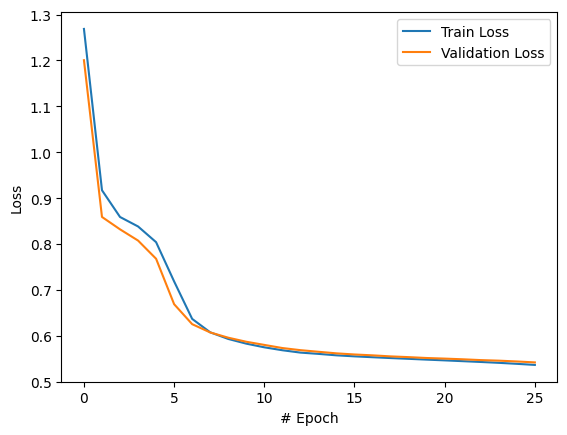

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5418493738837037 to 0.5394693688482568
Epoch:  27/50 | Training Loss:  0.5338224588343804 | Testing Loss:  0.5394693688482568


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5394693688482568 to 0.5358386444986313
Epoch:  28/50 | Training Loss:  0.5311255730086978 | Testing Loss:  0.5358386444986313


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5358386444986313 to 0.5323890268654735
Epoch:  29/50 | Training Loss:  0.5282650152348584 | Testing Loss:  0.5323890268654735


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5323890268654735 to 0.5281526379786413
Epoch:  30/50 | Training Loss:  0.5252323581935447 | Testing Loss:  0.5281526379786413


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5281526379786413 to 0.5231441447220135
Epoch:  31/50 | Training Loss:  0.5219229933638007 | Testing Loss:  0.5231441447220135


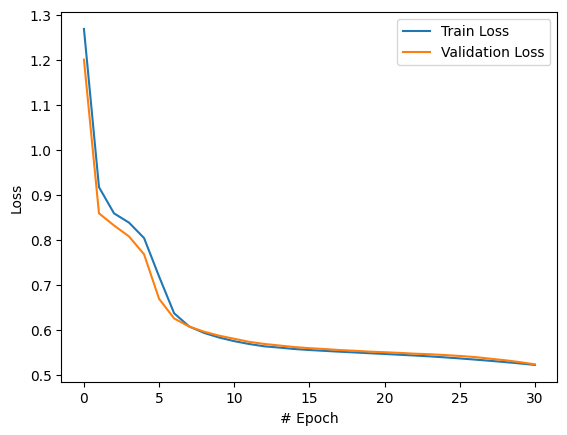

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5231441447220135 to 0.5177763498598535
Epoch:  32/50 | Training Loss:  0.5181968431665281 | Testing Loss:  0.5177763498598535


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5177763498598535 to 0.5133432270427499
Epoch:  33/50 | Training Loss:  0.5143366694450381 | Testing Loss:  0.5133432270427499


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5133432270427499 to 0.5099385981967969
Epoch:  34/50 | Training Loss:  0.5108111725090452 | Testing Loss:  0.5099385981967969


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5099385981967969 to 0.5051956935496842
Epoch:  35/50 | Training Loss:  0.5069922427583186 | Testing Loss:  0.5051956935496842


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5051956935496842 to 0.5015370725993775
Epoch:  36/50 | Training Loss:  0.5030391165188385 | Testing Loss:  0.5015370725993775


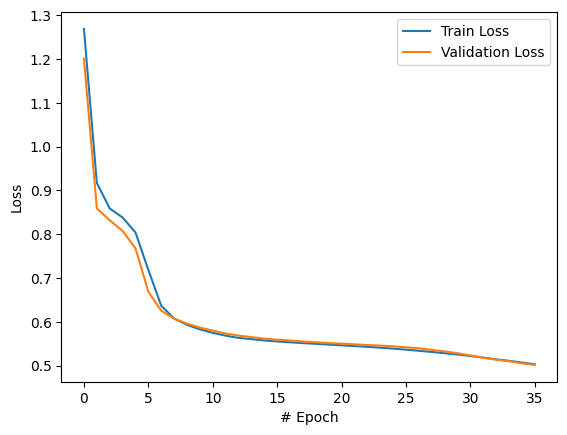

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.5015370725993775 to 0.4985440254359325
Epoch:  37/50 | Training Loss:  0.4994620227295429 | Testing Loss:  0.4985440254359325


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.4985440254359325 to 0.49677363770179656
Epoch:  38/50 | Training Loss:  0.4963683598530217 | Testing Loss:  0.49677363770179656


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.49677363770179656 to 0.49566886065615623
Epoch:  39/50 | Training Loss:  0.4934233859459066 | Testing Loss:  0.49566886065615623


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.49566886065615623 to 0.49423154914941125
Epoch:  40/50 | Training Loss:  0.49074723239270773 | Testing Loss:  0.49423154914941125


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.49423154914941125 to 0.49319769260901036
Epoch:  41/50 | Training Loss:  0.4882856856591954 | Testing Loss:  0.49319769260901036


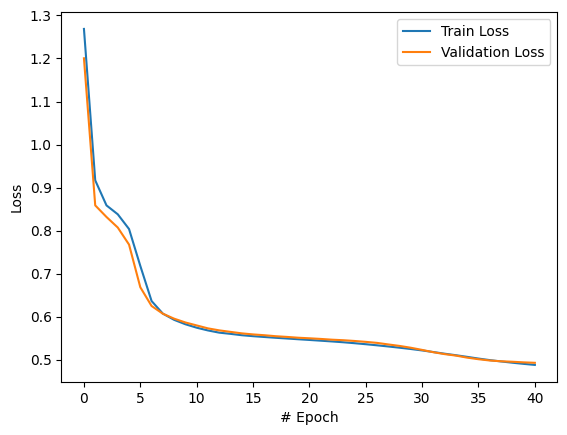

  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.49319769260901036 to 0.49222772093328043
Epoch:  42/50 | Training Loss:  0.4860743869165456 | Testing Loss:  0.49222772093328043


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.49222772093328043 to 0.4914826432025761
Epoch:  43/50 | Training Loss:  0.48428735870011813 | Testing Loss:  0.4914826432025761


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.4914826432025761 to 0.4912119245262954
Epoch:  44/50 | Training Loss:  0.4826491436973119 | Testing Loss:  0.4912119245262954


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.4912119245262954 to 0.49037662081919636
Epoch:  45/50 | Training Loss:  0.4814373492083939 | Testing Loss:  0.49037662081919636


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.49037662081919636 to 0.4897803726326445
Epoch:  46/50 | Training Loss:  0.4804050505161291 | Testing Loss:  0.4897803726326445


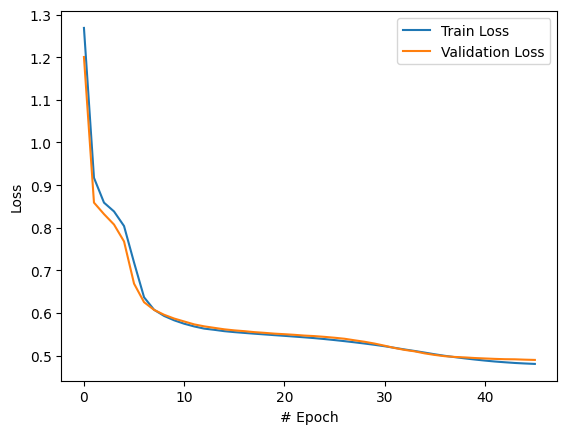

  0%|          | 0/805 [00:00<?, ?it/s]

Epoch:  47/50 | Training Loss:  0.4793787695236093 | Testing Loss:  0.4898161119030371


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.4897803726326445 to 0.48929932417703925
Epoch:  48/50 | Training Loss:  0.4785272242119593 | Testing Loss:  0.48929932417703925


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.48929932417703925 to 0.4886693480440759
Epoch:  49/50 | Training Loss:  0.4777309486214418 | Testing Loss:  0.4886693480440759


  0%|          | 0/805 [00:00<?, ?it/s]

Min loss changed from 0.4886693480440759 to 0.48833174467382584
Epoch:  50/50 | Training Loss:  0.4770314068157477 | Testing Loss:  0.48833174467382584


In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

epochs = 50
model = MODEL_GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00002, weight_decay=5e-4)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=5e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=1, factor=0.5)

model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_A2' + '.pth'
os.makedirs("/kaggle/working/model_trained" , exist_ok =True)
train_losses, test_losses = train(train_loader, test_loader, prog_bar=True)

# TESTING

## Metrics

In [41]:
def f1_comp(y_true,y_pred):
    f1 = []
    for i in range(100): 
        grnd = y_true >= i
        pred = y_pred >= i
        f1.append(sklearn.metrics.f1_score(grnd,pred))
    return f1

def acc_comp(y_true,y_pred):
    acc = []
    for i in range(100):
        grnd = y_true >= i
        pred = y_pred >= i
        cmp = np.sum(np.equal(grnd,np.squeeze(pred))) 
        acc.append(cmp/len(grnd)*100)
    return acc

In [42]:
# model_name = f'/kaggle/working/model_trained/{name}_loss' + 'no_inv_' + '.pth'
# model_name = "/kaggle/input/eachstation-node-v11/model_trained/4MPL_Conv_Custom_pT_loss_Outliers_removed_lossno_inv_A2.pth"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loaded_model = MODEL_GNN().to(device)
loaded_model.load_state_dict(torch.load(model_name))

<All keys matched successfully>

In [43]:
import numpy as np
import sklearn.metrics
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

In [44]:
y_true_all = []
y_pred_all = []
# Assuming you have a test_loader and a model
test_los = 0
loaded_model.eval()
with torch.no_grad():
    for data in tqdm(test_loader, position=0):
        data = data.to(device)
        out = loaded_model(data)
#         preds.append(out.cpu().detach())
        
        # Collect true labels and predictions
        labels = data.y.cpu().numpy()
        y_true_all.extend(labels)
        y_pred_all.extend(out.cpu().detach().numpy())
        
        loss = CustompTLoss(out, data.y, min_PT)
        test_los += loss.cpu().detach().numpy() / len(test_loader)

# Convert collected labels and predictions to numpy arrays
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

y_true_all = y_true_all * scaler.scale_[34] + scaler.mean_[34]
y_pred_all = y_pred_all * scaler.scale_[34] + scaler.mean_[34]

# Calculate F1 scores and accuracy
f1_scores = f1_comp(y_true_all, y_pred_all)
accuracy_scores = acc_comp(y_true_all, y_pred_all)

# Calculate MAE
mae = sklearn.metrics.mean_absolute_error(y_true_all, y_pred_all)

100%|██████████| 403/403 [00:23<00:00, 17.08it/s]


In [45]:
scaler.scale_[34], scaler.mean_[34]

(3.9377537017281714, 5.766601620977638)

In [46]:
# Print results
print('Test_loss:', test_los)
print("F1 Scores:", f1_scores[-1])
print("Accuracy Scores:", accuracy_scores[-1])
print("Mean Absolute Error (MAE):", mae)

Test_loss: 0.4883317458570443
F1 Scores: 0.0
Accuracy Scores: 100.0
Mean Absolute Error (MAE): 0.8783503


In [47]:
import csv

# Data to be saved
results = {
    'Test_loss': test_los,
    'F1_Score': f1_scores[-1],
    'Accuracy_Score': accuracy_scores[-1],
    'MAE': mae
}

# Save to CSV
with open('evaluation_results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Metric', 'Value'])
    for key, value in results.items():
        writer.writerow([key, value])

print('Results saved to evaluation_results.csv')

Results saved to evaluation_results.csv


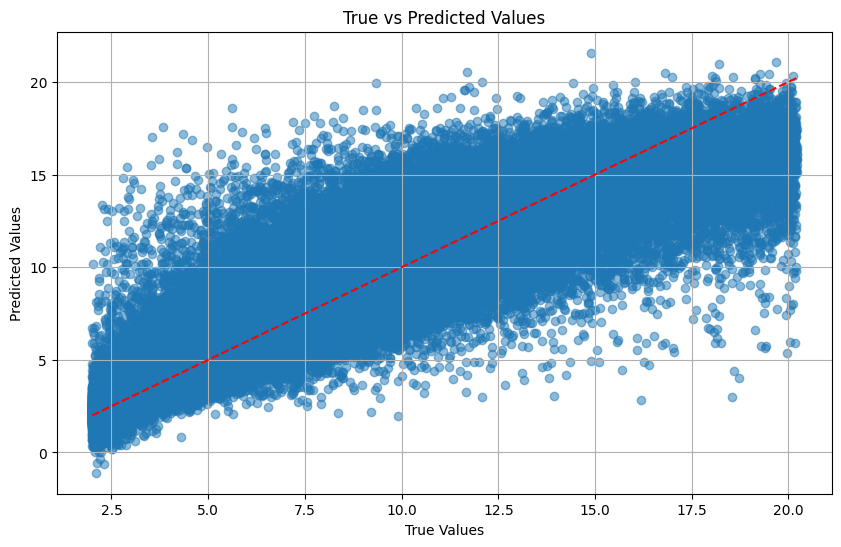

In [48]:
import matplotlib.pyplot as plt

# Assuming y_true_all and y_pred_all are defined and properly inverted

plt.figure(figsize=(10, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([min(y_true_all), max(y_true_all)], [min(y_true_all), max(y_true_all)], color='red', linestyle='--') # Line of equality
plt.grid(True)
plt.show()


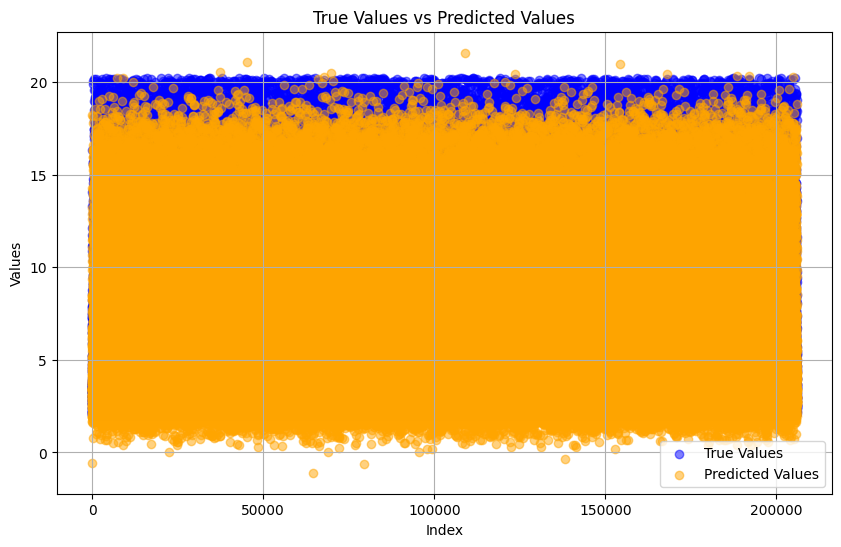

In [49]:
import matplotlib.pyplot as plt

# Example data for y_true_all and y_pred_all
# y_true_all = [your data here]
# y_pred_all = [your data here]

plt.figure(figsize=(10, 6))

# Plotting the true values
plt.scatter(range(len(y_true_all)), y_true_all, color='blue', alpha=0.5, label='True Values')

# Plotting the predicted values
plt.scatter(range(len(y_pred_all)), y_pred_all, color='orange', alpha=0.5, label='Predicted Values')

plt.xlabel('Index')
plt.ylabel('Values')
plt.title('True Values vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
from scipy.stats import norm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
import plotly.graph_objects as go
from scipy.optimize import curve_fit

In [51]:
def cuts(datain,datacheck,minval,maxval):
    dataout = datain[np.logical_and(datacheck > minval, datacheck < maxval)]
    
    return(dataout)

In [52]:
def plotgaussian(modelname, modelorreco, space, true, pred, varname, lower, upper, bins):
    resmeans = []
    stdevs = []
    bincenters = []
    samples = []
    
    #Compute residuals and bin width
    width = (upper - lower) / bins
    true = cuts(true, pred, lower, upper)
    pred = cuts(pred, pred, lower, upper)
    pred = cuts(pred, true, lower, upper)
    true = cuts(true, true, lower, upper)
    
    resids = true - pred
    
    #Create gaussian plot for each bin
    for i in range(bins):
        #Find bin dimensions
        lowertemp = lower + width * i
        uppertemp = lower + width * (i + 1)
        bincentertemp = (uppertemp + lowertemp) / 2
        
        #Cut the residuals to within lower and upper range along true values
        residscut = cuts(resids, 
                         true, 
                         lowertemp, 
                         uppertemp)
        
        varnametemp = '%s Residuals Distribution (%.2f to %.2f)' % (varname, 
                                                                    lowertemp, 
                                                                    uppertemp)
        residscut.sort()
        
        #Computer statistics for residuals
        resmeantemp, resstdtemp = norm.fit(residscut)
        samplestemp = len(residscut)
        pdf = stats.norm.pdf(residscut, resmeantemp, resstdtemp)
        
        #Plot histogram of residuals
        plt.hist(residscut, 
                 bins=bins, 
                 histtype='step', 
                 color='blue', 
                 density=1, 
                 label='Residuals')
        
        #Plot the normal curve fitted to the residuals
        plt.plot(residscut, 
                 pdf, 
                 label='Normal Curve', 
                 color='black')
        plt.title(varnametemp)
        
        #Plot the residuals mean as a vertical line
        plt.axvline(resmeantemp, 
                    label='Mean: %.2f' % resmeantemp, 
                    color='red')
        plt.xlabel('Stdev: %.2f (samples: %.i)' % (resstdtemp, 
                                                   samplestemp))
        
        #Plot the full-width half maximum range
        plt.axvspan(resmeantemp - resstdtemp / 2,
                    resmeantemp + resstdtemp / 2,
                    facecolor='g',
                    alpha=.3,
                    label='Stdev')        
        plt.legend()
        plt.savefig(f"{space}_gaussian.png", bbox_inches='tight')
        plt.close()
        
        #Append values to lists to be used by scatter() function
        resmeans.append(resmeantemp)
        samples.append(samplestemp)
        stdevs.append(resstdtemp)
        bincenters.append(bincentertemp)
    
    resmean = np.mean(resids)
    stddev = np.std(resids)    
    
    return resmeans, stdevs, bincenters, samples, resmean, stddev

In [53]:
resmeans, fwhms, bincenters, samples, resmean, stddev = \
    plotgaussian(model_name, 
                 'Model', 
                 "/kaggle/working/", 
                 y_true_all, 
                 y_pred_all, 
                 'pT', 
                 min_PT, 
                 max_pT, 
                 100)

In [54]:
def heatmap(modelname, modelorreco, space, true, pred, varname, lower, upper, bins):
    #Get histogram dimensions and data using numpy
    heatmap, xedges, yedges = np.histogram2d(true, 
                                             pred, 
                                             bins=bins, 
                                             range=[[lower, upper], [lower, upper]])
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    #Plot heatmap
    plt.imshow(heatmap.T, 
               extent=extent, 
               origin='lower')
    plt.plot([lower, upper], 
             [lower, upper], 
             color='blue')
    fig = plt.gcf()
    plt.set_cmap('gist_heat_r')
    plt.xlabel('%s True' % varname)
    plt.ylabel('%s Pred' % varname)
    plt.title('Frequency Heatmap')
    plt.xlim(lower, upper)
    plt.ylim(lower, upper)
    plt.colorbar()
    fig.savefig(f"{space}_heatmap.png")
    plt.close()

In [55]:
heatmap(model_name, 
            'Model', 
            "/kaggle/working/", 
            y_true_all, 
            y_pred_all, 
            'pT', 
            min_PT, 
            max_pT, 
            100)

In [56]:
def scatter(modelname, space, metrics, bincenters, samples, varname, prednames, metricname):
    bincenters = np.array(bincenters)
    #Check that the bin centers match between the two datasets
    if (np.std(bincenters[:,0]) > .0001) or (np.std(bincenters[:,-1]) > .0001):
        print('Scatter plot failed due to different bincenters')
        print(bincenters)
        return
    else:
        #Create subplots for scatter and ratio
        fig,axs = plt.subplots(2, gridspec_kw={'height_ratios':[3,1]})
        axs[0].set_ylabel(metricname)
        axs[0].set_title('Residuals %s vs %s' % (metricname,
                                                varname))
        
        for i in range(len(prednames)):
            #Find the width and range of bins
            width = (bincenters[i][-1] - bincenters[i][-2]) / 2
            lower = min(bincenters[i]) - width
            upper = max(bincenters[i]) + width        

#             if i == 0:
#                   dif1 = np.abs(metrics[i])
#             elif i == 1:
#                   dif2 = np.abs(metrics[i])
                    
            if i == 0:
                  metric1 = np.array(metrics[i])
            elif i == 1:
                  metric2 = np.array(metrics[i])

            print(np.shape(metrics))
            #Create the scatterplot
            axs[0].scatter(bincenters[i], 
                           metrics[i], 
                           label=prednames[i])
            axs[0].axhline(y=0)


            #Use standard error of the mean for y error and bin width for x error
            axs[0].errorbar(bincenters[i],
                            metrics[i],
                            xerr=(bincenters[i][-1] - bincenters[i][-2]) / 2,
                            yerr=metrics[i] / np.sqrt(samples[i]),
                            linestyle='')
        axs[0].legend()
        axs[0].set_xlim([lower,upper])
        
#         dif = dif1 - dif2
#         #Create ratio subplot
#         axs[1].scatter(bincenters[0], dif)
#         axs[1].axhline(y=0)
#         axs[1].set_xlim([lower, upper])
#         axs[1].set_ylabel('|%s| - |%s|' % (prednames[0], prednames[1]))
#         axs[1].set_xlabel('%s' % varname)
        
        #Plot ratio subplot for first 2 data sets
        axs[1].scatter(bincenters[i], metric1 / metric2)
        axs[1].axhline(y=1)
        axs[1].set_xlim([lower,upper])
        axs[1].set_ylim([0.5,2.0])
        axs[1].set_yscale('log', basey=2)
        axs[1].set_ylabel('%s / %s' % (prednames[0],
                                       prednames[1]))
        axs[1].set_xlabel('%s' % varname)
        
        #Save plot
        fig.savefig('./Plots/%s/Comparison/%s/%s_%s_scatter' % (modelname, 
                                                                space,
                                                                varname,
                                                                metricname), bbox_inches='tight')
        plt.close()